In [1]:
from fastai.vision.all import *

In [2]:
import fastai
fastai.__version__

'2.5.3'

In [3]:
path = Path("../input/indoor-scenes-cvpr-2019/indoorCVPR_09/")
Path.BASE_PATH = path
path.ls()

(#1) [Path('Images')]

# Dataset and Dataloader

In [4]:
def custom_splitter(train_name, valid_name, train_pct):
    def fn(name_list):
        train_idx, valid_idx = RandomSplitter()(name_list)
        np.random.shuffle(train_idx)
        train_len = int(len(train_idx) * train_pct)
        valid_len = int(len(valid_idx)* train_pct)
        return train_idx[0:train_len], valid_idx[0:valid_len]
    return fn

In [5]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  get_y = parent_label,
                  splitter=custom_splitter(train_name="train_name", valid_name="valid_name", train_pct=0.5),
                  item_tfms = Resize(224))

In [6]:
ds = dblock.datasets(path)
len(ds), len(ds.train), len(ds.valid)

(15620, 6248, 1562)

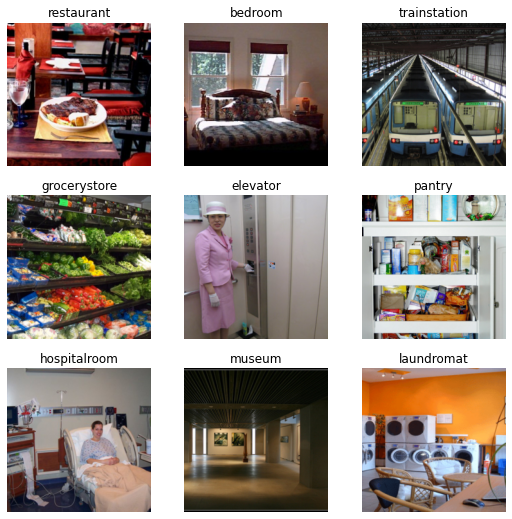

In [7]:
dls = dblock.dataloaders(path)
dls.show_batch()

# Model

In [8]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,3.471267,1.838512,0.521127,01:45


epoch,train_loss,valid_loss,accuracy,time
0,1.872036,1.441217,0.592830,01:28
1,1.354037,1.278428,0.639565,01:28
2,0.841518,1.207653,0.663892,01:29
3,0.525236,1.177127,0.672855,01:27
4,0.354479,1.164882,0.676056,01:27


In [9]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,3.450125,1.671529,0.555698,01:25


epoch,train_loss,valid_loss,accuracy,time
0,1.731661,1.291673,0.635723,01:29
1,1.202245,1.149322,0.668374,01:29
2,0.651493,1.090826,0.704866,01:29
3,0.351624,1.047656,0.715109,01:29
4,0.202846,1.045777,0.713188,01:35


# Data Augmentation

In [ ]:
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
dls_test = dblock.new(item_tfms=Resize(360), 
                      batch_tfms=batch_tfms)
dls = dls_test.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1, figsize=(6,7))

In [12]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,3.499452,1.745269,0.535851,01:52


epoch,train_loss,valid_loss,accuracy,time
0,1.863400,1.287167,0.631242,01:50
1,1.408451,1.171057,0.665173,01:48
2,0.980886,1.042672,0.701665,01:46
3,0.635827,0.982442,0.716389,01:47
4,0.473343,0.979048,0.709987,01:48


**model interpretation**

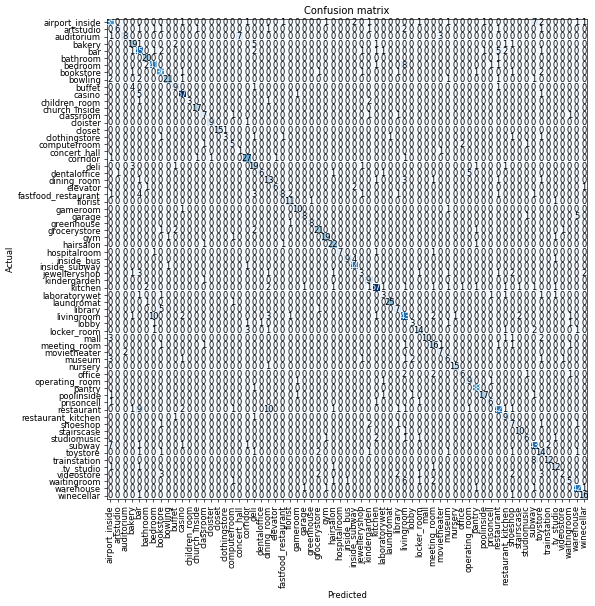

In [13]:
#width 600
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [14]:
interp.most_confused(3)

[('livingroom', 'bedroom', 10),
 ('restaurant', 'dining_room', 10),
 ('restaurant', 'bar', 9),
 ('bedroom', 'livingroom', 8),
 ('trainstation', 'subway', 8),
 ('airport_inside', 'subway', 7),
 ('auditorium', 'concert_hall', 7),
 ('subway', 'airport_inside', 7),
 ('waitingroom', 'livingroom', 6),
 ('bakery', 'deli', 5),
 ('bar', 'restaurant', 5),
 ('casino', 'bar', 5),
 ('dentaloffice', 'operating_room', 5),
 ('garage', 'warehouse', 5),
 ('library', 'bookstore', 5),
 ('buffet', 'bakery', 4),
 ('fastfood_restaurant', 'bar', 4),
 ('inside_bus', 'inside_subway', 4),
 ('auditorium', 'movietheater', 3),
 ('deli', 'bakery', 3),
 ('dining_room', 'livingroom', 3),
 ('fastfood_restaurant', 'deli', 3),
 ('jewelleryshop', 'bar', 3),
 ('livingroom', 'dining_room', 3),
 ('locker_room', 'corridor', 3),
 ('mall', 'airport_inside', 3),
 ('museum', 'airport_inside', 3),
 ('videostore', 'bookstore', 3),
 ('videostore', 'toystore', 3)]

**learning rate finder**

In [15]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(3, lr_max=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.957568,1.524374,0.588988,01:45
1,1.796157,1.209504,0.665813,01:44
2,1.223810,1.109698,0.683739,01:44


SuggestedLRs(valley=0.0006918309954926372)

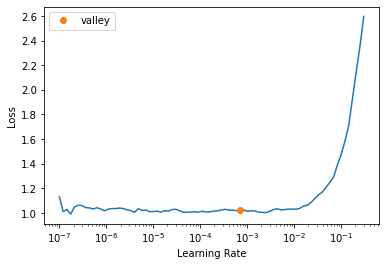

In [16]:
learn.lr_find()

In [17]:
learn.unfreeze()

SuggestedLRs(valley=9.120108734350652e-05)

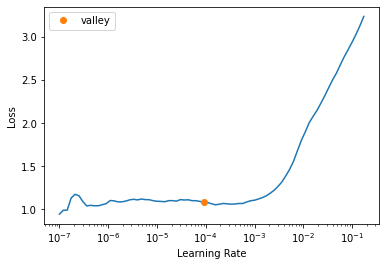

In [18]:
learn.lr_find()

In [19]:
learn.fit_one_cycle(5, lr_max=slice(5e-6, 5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.028646,1.056995,0.704225,01:47
1,0.930935,1.002714,0.715749,01:47
2,0.736994,0.953472,0.729193,01:48
3,0.567498,0.933661,0.734955,01:52
4,0.448553,0.929982,0.739437,01:52


**Full dataset**

In [20]:
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  get_y = parent_label,
                  splitter=custom_splitter(train_name="train_name", valid_name="valid_name", train_pct=0.8),
                  item_tfms = Resize(360),
                  batch_tfms=batch_tfms)

In [21]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(3, lr_max=3e-3)
learn.unfreeze()
learn.fit_one_cycle(5, lr_max=slice(5e-6, 5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,2.894717,1.456199,0.603713,01:49
1,1.741036,1.170354,0.663252,01:45
2,1.192076,1.080546,0.681818,01:44


epoch,train_loss,valid_loss,accuracy,time
0,1.019474,1.043081,0.693342,01:46
1,0.957593,0.981494,0.710627,01:45
2,0.742134,0.940355,0.726633,01:46
3,0.557953,0.921464,0.731114,01:48
4,0.472325,0.916531,0.734955,01:49
